<a href="https://colab.research.google.com/github/Mjloturco/musicstreamnet/blob/main/Parallel_Input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiple Parallel Input

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from datetime import datetime 
import numpy as np 
import tensorflow as tf
import pandas as pd

from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed, Input
from keras.layers.merge import concatenate
from tensorflow.keras.models import Model 


from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Data Preprocessing

### Time Series

In [6]:
# df = pd.read_csv('/content/drive/My Drive/cs137/project/spotify_daily_song_major.csv')
df = pd.read_csv('/content/drive/My Drive/cs137/project/spotify_daily_charts.csv')

In [7]:
df = df.drop(columns=['track_name', 'artist', 'position'])
df.head()

timesteps = df['date'].unique()

In [8]:
df_pivot = pd.pivot_table(df, values='streams', index=['date'], columns=['track_id'])
df_pivot.head()

track_id,000xQL6tZNLJzIrtIgxqSl,003eoIwxETJujVWmNFMoZy,007d7JT41sSc1HqWTs4uw7,0087fDVeNhuyMtST91RMjv,00bAw28lKcHj3B94a1wJle,00lNx0OcTJrS3MKHcB80HY,00mBzIWv5gHOYxwuEJXjOG,011GTFfE8rqTRMhz5g8IAW,017PF4Q3l4DBUiWoXk4OWT,01QdEx6kFr78ZejhQtWR5m,01YEqVPCm0vqRLA9w43bic,01dmH2IPkrLNWIMPNXlreE,01eo8yhZDkzYuog8FzYzgV,01iyINEYgPQ7ThMZuHUsqS,01k24g94i1JvkFLQmVEdCd,01uk7IzZyFNfQTDBXxx6NB,0247StOpd3AkeBQzANX4Zf,029B34AzPVXzOQCyaJpkdH,02FaKXXL7KUtRc7K0k54tL,02GtNoUv85fOPEaCTlpYzr,02WacdrRpm4zlP8H7X6bnQ,02q0ZnV2L4XByzEvWZJqBC,031mgKcbAk6cL9ZpfIEq4K,034KyQEk7IhbLtniVhBErj,03B2SfXuvDh1m9F4tqrX07,03T4ttRCiLXST6MZjeMwmR,03VNgdCL9t8aPyvwZecglI,03iCbZaM4OkRR4We6wIzvx,03o4HPzUwftpgAPNQSuaBS,03wvlNaxFKB9sge4U6vyPE,042x9bsUBWW2fJgJ6fUh61,045vckAeaQEbJ3vmatyBWt,04CttTezSnv71USiiG9mIo,04DwTuZ2VBdJCCC5TROn7L,04JL2liXXV9B9coeGuUsPw,04ZTP5KsCypmtCmQg5tH9R,051Z51PfIFgEe1gdo1vl6B,053ZzdU3Rya4NMxiWMPqnq,05ABOPiW13nqIedJfqmfPM,05CwHjIk71RXVU40boRMnR,05KOgYg8PGeJyyWBPi5ja8,05W4TSNqPEXtKdejLVRQrm,05mAIVLkIWc2d1UBYZBCp8,05mDaV9Vb3wrzjF6OPZnhq,06ANmvjPpUeh8QQAAAcThx,06FCvd7rrRcF3DdvWH5Isp,06Pvy98db25O7wlfFFFIRM,06Vthiq8nNDuT5nOcch535,06cUybZMETs4i3yQO1f7p3,073ILU1C3APNRGF66VhtyA,0742PcMPo2Akmo4vHC29VZ,07CYRI5dwRevOhthkHU58X,07JZJ9YJRaiUAz9Bv8wgwH,07KegcFokV4bBD1GvO1j6L,07MW63ok3ptSKwaTWEN0o8,07Oz5StQ7GRoygNLaXs2pd,07ipXN6CNTw34qwSYePKpg,07s9NNOT0sZQp7TyolLLgu,0815caqt2Lytro5EIzMufT,083Qf6hn6sFL6xiOHlZUyn,08LwMWf5Tcfsd752EPzFV0,08WPvDEsHvTFuB9w8tC2OS,08bNPGLD8AhKpnnERrAc6G,08fa9LFcFBTcilB3iq2e2A,08sQknOKXt3Thw6kw3pUu1,0939D7aT18uBDS2MTjWzct,09IStsImFySgyp0pIQdqAc,09KlDlkOYuC5x6hOaM7vaP,09PGubKAMryhOWv1LHpCYz,09oZ9eXQ2fo6YDrPzJqAoP,09ts3GnICqYEU5PkQCpJK3,0AG2l0IboWNSwjUkMr2Aq7,0ARK753YaiJbpLUk7z5yIM,0AZjL7QqObm13VxPA078uz,0AaV4MJrgmLV3XhoiWXjjb,0AiUFrU3Bj0ZzYFSWoAM0O,0Aii1ZdrQwkas2lrRFz6ZY,0AkQbXGN4KG34TS7xLrM68,0At2qAoaVjIwWNAqrscXli,0AtP8EkGPn6SwxKDaUuXec,0B0tYbVp7pDQAqKDhgMeaL,0B7wvvmu9EISAwZnOpjhNI,0B8B8cVRFIG1yznoQe7c9s,0BCPKOYdS2jbQ8iyB56Zns,0BEpSEV02FM1N5gcw2fsJC,0BOEuUKoHdy8in20fG5smd,0BSd5u6lQJWDoNVMuBYBiA,0BaMZMMEG7GWrUYsoGw8Yg,0BkKdJSpKqzYLEneerSHq3,0BlY60NrN0fFWbdW3RW40q,0BnTBAGmr9FtYwkZrwKhwS,0Bv25hxffynRiTkRvlPxw0,0C7RxcoJUdt0EDtQLuOFc6,0CBFOvHlyqy30Q5tbyNHfQ,0CLnkxpa3M4eA3HeGaERat,0CNjoQozZP0mB9rKVdrKGx,0CZ8lquoTX2Dkg7Ak2inwA,0CcQNd8CINkwQfe1RDtGV6,0ClPIeT6MSgfSgQ9ZrJbAq,0Clb9aiXWa0dvVff5aN4VN,0CokSRCu5hZgPxcZBaEzVE,0CyydmXI4QhgUWrZsPOTXA,0D4yVl9Pn45xW2s63MFCmT,0D8ZpOXVjapLXrjz5VfZSD,0DC7Zs2qvAbNK1owWQ4mlL,0DdC92EziGIEN6j7kTCKQX,0DhkTGjEaIHaSxTfC14BFm,0DiDStADDVh3SvAsoJAFMk,0Dljpp52vCmtXi0E94qjfo,0Dn40gxVCMo5TkgS8Ik18Q,0Dq49j3dELbttQVUJbtn0c,0E3LHQbZTPLyw06z6XvmNn,0E4Y1XIbs8GrAT1YqVy6dq,0E6PsO3ymCfUh7pJQjBgkj,0E8eAVCGmOk78xebmDEBfF,0E9ZjEAyAwOXZ7wJC0PD33,0EQMrxdeiBhry9JCxskko3,0EkPuwTCZxRPpOHT4AvGgE,0Eqg0CQ7bK3RQIMPw1A7pl,0ErjxyZ4qHQVs5umCBIClk,0ExtPzAWi4arQz6kaabm02,0F9Xy6OTbkqOv94pklkwKu,0FDzzruyVECATHXKHFs9eJ,0FMjqbY3aWo1QDbo3GwXib,0Fh6hgq979963fIxr2VBF2,0FuTx2s3YH1ppmtiM6l0zI,0G5qmu4TsdUH19zdcbI9Ui,0GGfPhGuWC2JGc7hlvjLXa,0GHR9XDrf3j7OI9GWy4915,0GHwNr0lqf8jpc9wesmnHo,0GOJobsbOSIF99y6CGr5o6,0GPJSHYaXh8rZSSJoUMgyl,0GU5GuJQQEnnREO2FxnVPT,0GUbhhI5fRx7BlqlqlhjuB,0GVKkD74xcixRYYG3zv1NL,0GVuLQtPXFaL18ijEOqoAa,0Gl5s8IhMmQE5YQwM8Qx1J,0GuAFGEkbWayjhWdlYlr7K,0GxQ1A5L9xnMOytbP6eKBG,0GxgZ6u2fZAsogiMs1rgMl,0GzuHFG4Ql6DoyxFRnIk3F,0H4ugk6rhnXmTl47ayy9O5,0HMjXBAZmSYOTTi33WpMso,0HQnJee8ShSDu2AYwibxst,0HVv5bEOiI9a0QfgcASXpX,0HYmOF3tCkYejosr1HTMhV,0HZ3OUVrGHxttD2EuHqRm3,0I20rLT2MJDhcF96AjbNYo,0I4W2KgA6nBaphEf6g8DLE,0I5Z0p0cLWdyJNC6sqMTwD,0IUksMHKob4SvJJL6QlQVi,0Ie5uiv54KgCr7P4sYDTHl,0IpbLjg5HE1Ju4k1rhYqvp,0Iu5xWN9wtWHp5daIj0Mjb,0JEqGkvUiMTQmFY6sgL9kg,0JM8LI4HxrQs2Reqr2naYo,0JP9xo3adEtGSdUEISiszL,0JQHGu03YJikcND4SENdiW,0JeDwT1t3gcrAH29RA0yvm,0JiVRyTJcJnmlwCZ854K4p,0Jlcvv8IykzHaSmj49uNW8,0JzwzRDkwZr8s1WRfNgUqA,0K2UmT0JOcEaLssWda2703,0KKkJNfGyhkQ5aFogxQAPU,0KR2W3St74th8z3LS94Ffh,0KaUTLgQTHW0hIRi9vuPEF,0KeZ6mv7rL5wfF7TuxSUdk,0KmgJyW4GDgonqsoyx0CZ3,0KoiMHhqKLoL4xM54rcWYY,0LAh3hfeuUekvLm3Nq6MmA,0LGCloCfw3fk1XQh0zbrs1,0LtVx5vsq9nfpGsWgjUin6,0Lw6aQcBFWTQ9m4MSwwwes,0M1A9wInEHil

In [9]:
# filter out songs without a lot of stream counts 
df_pivot = df_pivot.dropna(axis=1, thresh=800)

# fill NaN values with 0???
# df_pivot = df_pivot.fillna(0)
df_pivot = df_pivot.interpolate(method='linear', axis=1, limit=2)
df_pivot = df_pivot.fillna(0)

In [10]:
# pd.options.display.max_rows = None
# df_pivot.iloc[:, 1]

In [11]:
# get last 20% of songs
split = df['date'].unique()[-int(1598*0.2)]

df_train = df_pivot.loc[:split]
df_test = df_pivot.loc[split:]

In [12]:
# min-max scaling 

from sklearn.preprocessing import MinMaxScaler 

l = [i for i in df_pivot if i != 'date']

scaler = MinMaxScaler() 
scaled_train = scaler.fit_transform(df_train[l])
scaled_test = scaler.fit_transform(df_test[l])


In [13]:
def split_sequence(sequence, look_back, forecast_horizon):
  """
  splitting sequence
  """
  X, y = list(), list() 
  
  for i in range(len(sequence)):

    lag_end = i + look_back
    forecast_end = lag_end + forecast_horizon 

    if forecast_end > len(sequence):
      break 

    seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
    X.append(seq_x)
    y.append(seq_y)
  
  return np.array(X), np.array(y)


# splitting parameters 
LOOK_BACK = 12
FORECAST_RANGE = 1
n_features = len(l)

X_train, y_train = split_sequence(scaled_train, LOOK_BACK, FORECAST_RANGE)
X_test, y_test = split_sequence(scaled_test, LOOK_BACK, FORECAST_RANGE)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(1268, 12, 63) (1268, 1, 63) (307, 12, 63) (307, 1, 63)


### Metadata

In [14]:
meta = pd.read_csv('/content/drive/My Drive/cs137/project/spotify_tracks_augmented.csv').set_index('track_id')

# select only track IDs that we've filtered above 
meta = meta.loc[df_pivot.columns]


# drop columns 
dropcols = ['Unnamed: 0', 'artist_id', 'type', 'id', 'uri', 
            'track_href', 'analysis_url']

meta = meta.drop(columns=dropcols)

metasize = meta.shape[1]

# show metadata
print(meta.shape)
meta

(63, 13)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
track_id,,,,,,,,,,,,,
00mBzIWv5gHOYxwuEJXjOG,0.518,0.7620,7.0,-3.907,1.0,0.0305,0.08510,0.000000,0.1480,0.271,155.985,285138.0,4.0
01YEqVPCm0vqRLA9w43bic,0.404,0.1740,9.0,-10.192,1.0,0.0312,0.89300,0.000000,0.0977,0.324,87.636,230453.0,4.0
06cUybZMETs4i3yQO1f7p3,0.710,0.3730,5.0,-10.611,0.0,0.0618,0.17900,0.000000,0.1560,0.141,127.064,211200.0,4.0
0815caqt2Lytro5EIzMufT,0.459,0.4270,7.0,-7.734,1.0,0.0267,0.11400,0.000000,0.1680,0.354,139.902,195493.0,3.0
0Dljpp52vCmtXi0E94qjfo,0.389,0.2730,6.0,-7.697,1.0,0.0362,0.70500,0.000000,0.1170,0.176,134.124,255608.0,4.0
0Eqg0CQ7bK3RQIMPw1A7pl,0.559,0.4220,11.0,-11.890,1.0,0.1950,0.70100,0.000002,0.0853,0.191,74.002,286928.0,4.0
0HZ3OUVrGHxttD2EuHqRm3,0.558,0.5530,4.0,-6.669,1.0,0.0323,0.49200,0.000000,0.1160,0.251,134.263,291358.0,4.0
0KKkJNfGyhkQ5aFogxQAPU,0.853,0.5600,1.0,-4.961,1.0,0.0406,0.01300,0.000000,0.0944,0.860,134.066,206693.0,4.0
0Vmk6Ebk4QBq7r0VAz2a6s,0.668,0.4800,10.0,-5.469,1.0,0.0284,0.54900,0.000000,0.1120,0.277,119.903,245587.0,4.0


## Model

In [27]:
# configure callbacks 

checkpoint_filepath = 'path_to_checkpoint_filepath'

checkpoint_callback = ModelCheckpoint(
 filepath=checkpoint_filepath,
 save_weights_only=False,
 monitor='val_loss',
 mode='min',
 save_best_only=True)

early_stopping_callback = EarlyStopping(
 monitor='val_loss',
 min_delta=0.005,
 patience=10,
 mode='min'
)

rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, mode='min', patience=3, min_lr=0.001)

### Sequential

In [28]:
EPOCHS = 100
BATCH_SIZE = 32
VALIDATION = 0.1 

# SEQUENTIAL MODEL 
seq_model = Sequential()
seq_model.add(LSTM(12, activation='relu', input_shape=(LOOK_BACK, n_features)))
seq_model.add(RepeatVector(FORECAST_RANGE))
seq_model.add(LSTM(12, activation='relu', return_sequences=True)) 
seq_model.add(TimeDistributed(Dense(n_features)))

seq_model.compile(optimizer='adam', loss='mse')

seq_history = seq_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
                    validation_split=VALIDATION, callbacks=[early_stopping_callback])

Epoch 1/100
36/36 [==============================] - 2s 15ms/step - loss: 0.1399 - val_loss: 0.0711
Epoch 2/100
36/36 [==============================] - 0s 6ms/step - loss: 0.1005 - val_loss: 0.0417
Epoch 3/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0499 - val_loss: 0.0219
Epoch 4/100
36/36 [==============================] - 0s 6ms/step - loss: 0.0295 - val_loss: 0.0192
Epoch 5/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0241 - val_loss: 0.0192
Epoch 6/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0213 - val_loss: 0.0185
Epoch 7/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0192 - val_loss: 0.0178
Epoch 8/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0175 - val_loss: 0.0166
Epoch 9/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0157 - val_loss: 0.0156
Epoch 10/100
36/36 [==============================] - 0s 7ms/step - loss: 0.0139 - val_loss: 0.0145
Epoch 11

### Functional

In [29]:
swapped = np.swapaxes(meta, 0, 1)

swapped.shape

(13, 63)

In [46]:

EPOCHS = 100
BATCH_SIZE = 32
VALIDATION = 0.1 

#                examples, timesteps, song
# input train shape (1265, 12, 63)
# train out         (1265, 4, 63) 
# test in           (304, 12, 63)
# test out          (304, 4, 63)

song_count = 63

# MODEL 
time_series_input = Input(shape=(12, song_count))
lstm_out_size = 12
lstm_out = LSTM(lstm_out_size)(time_series_input)
repeat_out = RepeatVector(FORECAST_RANGE)(lstm_out)
lstm2_out = LSTM(12, activation='relu', return_sequences=True)(repeat_out) 
dense_layer = Dense(song_count)
td_out = TimeDistributed(dense_layer)(lstm2_out)

# METADATA + concatenation
meta_input = Input(shape=(metasize, song_count))
full_features = concatenate([td_out, meta_input], axis=1)
d1 = Dense(63, activation='relu')(full_features)
# d2 = Dense(63, activation='relu')(d1)

# #outputshape
# output = Dense(1, activation='linear')(d1)

# # create model 
fun_model = Model(inputs=[time_series_input, meta_input], outputs=d1)

# # compile 
# model.compile(loss='mse', optimizer='adam')
fun_model.compile(optimizer='adam', loss='mse')

# stack metadata to match shape 
tiled = np.tile(np.swapaxes(np.expand_dims(meta, axis=0), 1, 2), [1268, 1, 1])

print(fun_model.summary())

fun_history = fun_model.fit(x=[X_train[:,:, :song_count], tiled], y=y_train[:,:, :song_count], 
                            epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION, callbacks=[early_stopping_callback])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 12, 63)]     0           []                               
                                                                                                  
 lstm_10 (LSTM)                 (None, 12)           3648        ['input_7[0][0]']                
                                                                                                  
 repeat_vector_5 (RepeatVector)  (None, 1, 12)       0           ['lstm_10[0][0]']                
                                                                                                  
 lstm_11 (LSTM)                 (None, 1, 12)        1200        ['repeat_vector_5[0][0]']        
                                                                                            

## Evaluation

In [40]:
# pick which model we're evaluating 

model = fun_model
history = fun_history 

print(X_test.shape, meta.shape)
testmeta = np.tile(np.swapaxes(np.expand_dims(meta, axis=0), 1, 2), [307, 1, 1])
print(testmeta.shape)

test = [X_test, testmeta]

(307, 12, 63) (63, 13)
(307, 13, 63)


In [41]:
# Helper functions for model eval


def inverse_transform(y_test, yhat):
  """
  revert data back to original scale for evaluation
  """
  y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
  yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])

  yhat_inverse = scaler.inverse_transform(yhat_reshaped)
  y_test_inverse = scaler.inverse_transform(y_test_reshaped)

  return yhat_inverse, y_test_inverse 

  

def evaluate_forecast(y_test_inverse, yhat_inverse):
  """
  Evaluation metrics 
  """
  mse_ = tf.keras.losses.MeanSquaredError()
  mae_ = tf.keras.losses.MeanAbsoluteError()
  mape_ = tf.keras.losses.MeanAbsolutePercentageError() 

  mae = mae_(y_test_inverse,yhat_inverse)
  tf.print('mae:', mae)

  mse = mse_(y_test_inverse,yhat_inverse)
  tf.print('mse:', mse)

  mape = mape_(y_test_inverse,yhat_inverse)
  tf.print('mape:', mape)


In [44]:
yhat = model.predict(test, verbose=0)

yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

print(y_test_inverse.shape, yhat_inverse.shape, yhat.shape)
evaluate_forecast(y_test_inverse, yhat_inverse)

(307, 63) (4298, 63) (307, 14, 63)


InvalidArgumentError: ignored

In [34]:
print(yhat_inverse.shape, y_test_inverse.shape, y_test.shape, yhat.shape)

(4298, 63) (307, 63) (307, 1, 63) (307, 14, 63)


In [35]:
# timesteps, batches?, songs 
print(yhat.shape)
print(yhat_inverse.shape)

(307, 14, 63)
(4298, 63)


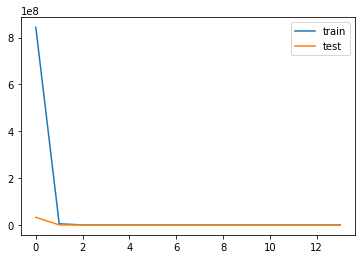

In [38]:
import matplotlib.pyplot as plt 

# visualize loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


<Figure size 2304x2304 with 0 Axes>

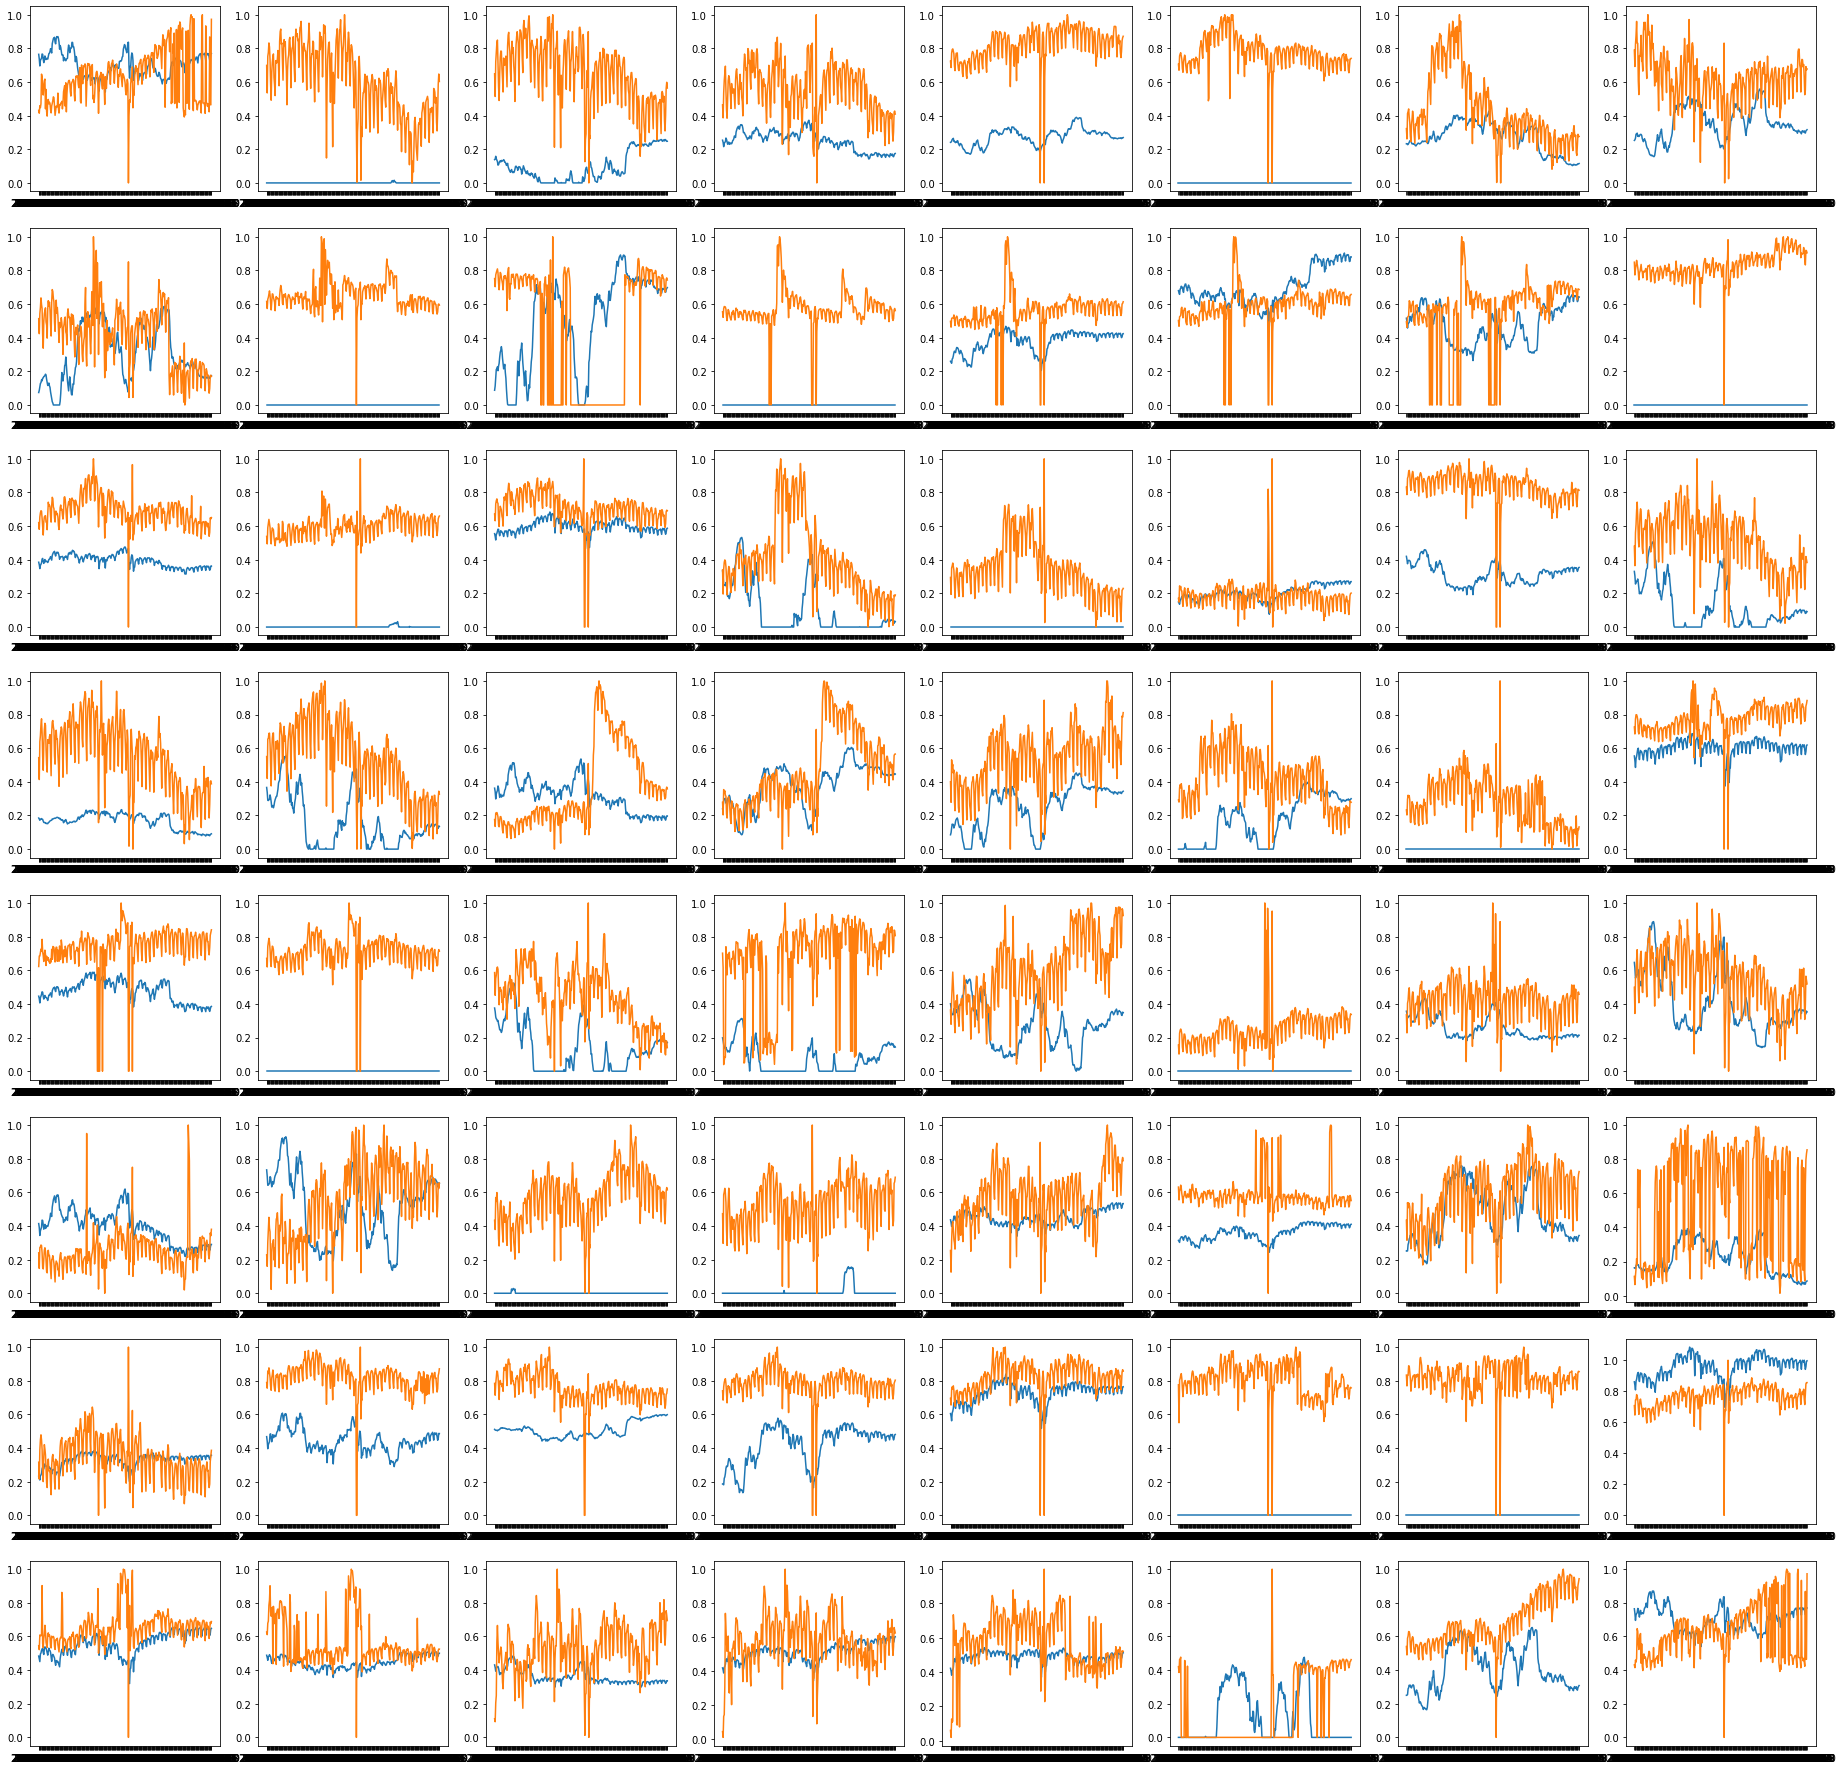

In [37]:
# plt.plot(timesteps[-304:], yhat, label='pred')
# plt.plot(timesteps[-304:], y_test, label='test') 
# plt.show()
plt.figure(figsize=(32, 32))

ntimesteps = yhat.shape[0]

fig, axs = plt.subplots(8, 8, figsize=(32, 32))
for i, ax in enumerate(axs.flat):
  ax.plot(timesteps[-ntimesteps:], yhat[:, 0, i-1], label='pred')
  ax.plot(timesteps[-ntimesteps:], y_test[:, 0, i-1], label='test')

plt.show()

# plt.plot(timesteps[-304:], yhat[:, 0, 16], label='pred')
# plt.plot(timesteps[-304:], y_test[:, 0, 16], label='test')
# plt.legend()
# plt.show()

